In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/Practice Module/Violence-Detection')
pwd = os.getcwd()
print(pwd)

/content/gdrive/My Drive/Practice Module/Violence-Detection


In [8]:
import cv2
import os
from glob import glob
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from random import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.layers import Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Check GPU coinfiguration in Colab
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())

Tensorflow version:  2.8.0
/device:GPU:0


In [9]:
with np.load("datasets/c3d_train_90f.npz") as npzfile:
    x_train = npzfile["X"]
    y_train = npzfile["Y"]
    
with np.load("datasets/c3d_test_90f.npz") as npzfile:
    x_val = npzfile["X"]
    y_val = npzfile["Y"]
    
print("Training data", x_train.shape, y_train.shape)
print("Validation data", x_val.shape, y_val.shape)

Training data (1280, 32, 32, 10, 1) (1280, 2)
Validation data (320, 32, 32, 10, 1) (320, 2)


In [10]:
c3d_model = load_model('c3d_model.h5')
model_name = 'c3d_model_90f_5fold'

In [11]:
folderpath      = pwd+'/'
filepath        = folderpath + model_name + "_weights.h5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+model_name +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+model_name+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/Practice Module/Violence-Detection/c3d_model_90f_5fold_weights.h5
Path to log:   /content/gdrive/My Drive/Practice Module/Violence-Detection/c3d_model_90f_5fold.csv


In [12]:
num_folds = 5
batch_size = 64
epochs = 50
verbosity = 0
# Merge inputs and targets
inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold, loss_per_fold = [], []
for train, val in kfold.split(inputs, targets):

    history = c3d_model.fit(inputs[train], targets[train],
                            validation_data = (inputs[val], targets[val]),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=verbosity,
                            callbacks=callbacks_list)
    
    # Generate generalization metrics
    scores = c3d_model.evaluate(inputs[val], targets[val], verbose=1)
    print(f'Score for fold {fold_no}: {c3d_model.metrics_names[0]} of {scores[0]}; {c3d_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

10/10 [==============================] - 0s 9ms/step - loss: 1.0711 - accuracy: 0.7563
Score for fold 1: loss of 1.0711305141448975; accuracy of 75.62500238418579%
10/10 [==============================] - 0s 8ms/step - loss: 0.4225 - accuracy: 0.8781
Score for fold 2: loss of 0.4224511682987213; accuracy of 87.8125011920929%
10/10 [==============================] - 0s 8ms/step - loss: 0.2346 - accuracy: 0.9656
Score for fold 3: loss of 0.23462221026420593; accuracy of 96.5624988079071%
10/10 [==============================] - 0s 9ms/step - loss: 0.1633 - accuracy: 0.9563
Score for fold 4: loss of 0.1633146107196808; accuracy of 95.6250011920929%
10/10 [==============================] - 0s 8ms/step - loss: 0.0645 - accuracy: 0.9875
Score for fold 5: loss of 0.06453751027584076; accuracy of 98.7500011920929%


In [13]:
# Load the un-seen data
with np.load("datasets/c3d_val_90f.npz") as npzfile:
    x_test = npzfile["X"]
    y_test = npzfile["Y"]

c3d_model.load_weights(filepath)
# Evaluate the deep learning model
y_pred = c3d_model.predict(x_test, verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Accuracy Score :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix
[[146  54]
 [ 55 145]]
Accuracy Score : 0.7275


In [ ]:
90f
Confusion matrix
[[146  54]
 [ 55 145]]
Accuracy Score : 0.7275

120f
Confusion matrix
[[155  45]
 [ 65 135]]
Accuracy Score : 0.725

150f
Confusion matrix
[[158  42]
 [ 48 152]]
Accuracy Score : 0.775

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


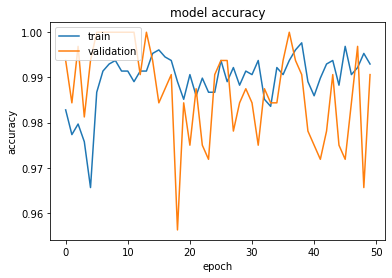

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


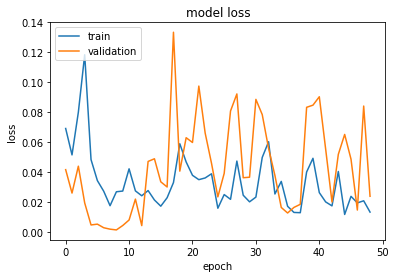

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('c3d_rgb_accuracy.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('c3d_rgb_loss.eps', format='eps', dpi=1000)
plt.show()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history, columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
df_history.to_csv('data/c3d_rgb_150f_5fold.csv')